# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.11KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

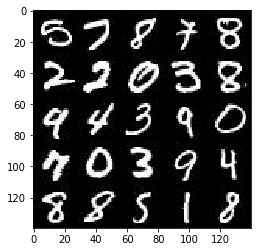

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

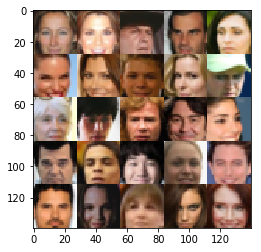

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, None)
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer shape is 28x28x3
        
        # Conv layer 1, resulting in 14x14x64
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        # According to Matt's suggestion, do not use batch normalization in layer 1
        # Leaky relu 1
        relu1 = tf.maximum(alpha * l1, l1)
        
        # Conv layer 2, resulting in 7x7x128
        l2 = tf.layers.conv2d(l1, 128, 5, strides=2, padding="same")
        # Batch normalization
        bn2 = tf.layers.batch_normalization(l2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # Conv layer 3, resulting in 4x4x256
        l3 = tf.layers.conv2d(l2, 256, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(l3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flattening layer
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        # Input shape is 100
        
        # Fully connected layer, reshaped, batch normalized, with leaky relu, 
        # resulting in 7x7x256
        l1 = tf.layers.dense(z, 7*7*256) 
        l1 = tf.reshape(l1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(l1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        # Transposed convolutional layer 1, batch normalized, with leaky relu, 
        # resulting in 14x14x128
        l2 = tf.layers.conv2d_transpose(l1, 128, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(l2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)

        # Transposed convolutional layer 1, batch normalized, with leaky relu, 
        # resulting in 28x28x64
        l3 = tf.layers.conv2d_transpose(l2, 64, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(l3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Output layer, resulting in 28x28x3
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_labels_real = tf.ones_like(d_model_real) * 0.9 # Apply Label smoothing
    d_labels_fake = tf.zeros_like(d_model_fake)
    g_labels = tf.ones_like(d_model_fake)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_fake))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # 1) Variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    # 2) Update operations
    updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [update for update in updates if update.name.startswith("discriminator")]
    g_updates = [update for update in updates if update.name.startswith("generator")]

    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
            
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model                
                steps += 1
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                # Get the losses and print them out
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator loss: {:.4f}...".format(train_loss_d),
                          "Generator loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator loss: 1.0391... Generator loss: 0.6836
Epoch 1/2... Discriminator loss: 1.0346... Generator loss: 0.6855
Epoch 1/2... Discriminator loss: 0.8843... Generator loss: 0.8599
Epoch 1/2... Discriminator loss: 0.6168... Generator loss: 1.3911
Epoch 1/2... Discriminator loss: 0.4379... Generator loss: 2.2922
Epoch 1/2... Discriminator loss: 0.3986... Generator loss: 2.7778
Epoch 1/2... Discriminator loss: 0.3768... Generator loss: 3.0769
Epoch 1/2... Discriminator loss: 0.3737... Generator loss: 3.1984
Epoch 1/2... Discriminator loss: 0.4086... Generator loss: 3.3557
Epoch 1/2... Discriminator loss: 0.4115... Generator loss: 3.7485


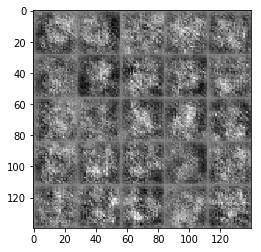

Epoch 1/2... Discriminator loss: 0.4050... Generator loss: 2.9132
Epoch 1/2... Discriminator loss: 0.5270... Generator loss: 3.3556
Epoch 1/2... Discriminator loss: 0.4973... Generator loss: 2.2178
Epoch 1/2... Discriminator loss: 0.6227... Generator loss: 1.5057
Epoch 1/2... Discriminator loss: 0.5995... Generator loss: 1.7119
Epoch 1/2... Discriminator loss: 0.8125... Generator loss: 1.0262
Epoch 1/2... Discriminator loss: 0.7150... Generator loss: 1.3765
Epoch 1/2... Discriminator loss: 0.9189... Generator loss: 2.3757
Epoch 1/2... Discriminator loss: 0.8630... Generator loss: 1.0592
Epoch 1/2... Discriminator loss: 1.0063... Generator loss: 0.8296


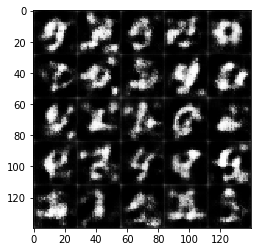

Epoch 1/2... Discriminator loss: 0.8987... Generator loss: 1.3671
Epoch 1/2... Discriminator loss: 0.9997... Generator loss: 1.5220
Epoch 1/2... Discriminator loss: 1.0892... Generator loss: 1.6804
Epoch 1/2... Discriminator loss: 1.0140... Generator loss: 1.5276
Epoch 1/2... Discriminator loss: 1.0367... Generator loss: 1.4821
Epoch 1/2... Discriminator loss: 1.0674... Generator loss: 1.5556
Epoch 1/2... Discriminator loss: 1.0380... Generator loss: 0.9497
Epoch 1/2... Discriminator loss: 1.0365... Generator loss: 1.0032
Epoch 1/2... Discriminator loss: 1.0177... Generator loss: 1.0427
Epoch 1/2... Discriminator loss: 1.0813... Generator loss: 0.8245


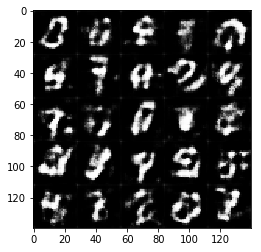

Epoch 1/2... Discriminator loss: 1.0118... Generator loss: 1.1411
Epoch 1/2... Discriminator loss: 1.1364... Generator loss: 0.7294
Epoch 1/2... Discriminator loss: 1.0680... Generator loss: 1.2499
Epoch 1/2... Discriminator loss: 1.0368... Generator loss: 0.9436
Epoch 1/2... Discriminator loss: 1.0783... Generator loss: 1.0829
Epoch 1/2... Discriminator loss: 1.0609... Generator loss: 1.1931
Epoch 1/2... Discriminator loss: 1.0303... Generator loss: 1.2088
Epoch 1/2... Discriminator loss: 1.1890... Generator loss: 0.7413
Epoch 1/2... Discriminator loss: 1.0861... Generator loss: 1.0476
Epoch 1/2... Discriminator loss: 1.1046... Generator loss: 0.9013


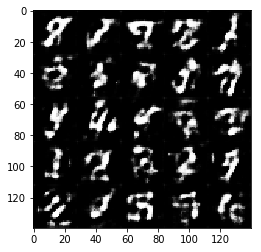

Epoch 1/2... Discriminator loss: 1.1319... Generator loss: 1.1887
Epoch 1/2... Discriminator loss: 1.1212... Generator loss: 1.2749
Epoch 1/2... Discriminator loss: 1.1181... Generator loss: 1.1510
Epoch 1/2... Discriminator loss: 1.1673... Generator loss: 0.8564
Epoch 1/2... Discriminator loss: 1.1340... Generator loss: 1.1284
Epoch 1/2... Discriminator loss: 1.1144... Generator loss: 1.0350
Epoch 2/2... Discriminator loss: 1.1565... Generator loss: 0.8848
Epoch 2/2... Discriminator loss: 1.1365... Generator loss: 1.2020
Epoch 2/2... Discriminator loss: 1.1656... Generator loss: 0.9411
Epoch 2/2... Discriminator loss: 1.1198... Generator loss: 1.1301


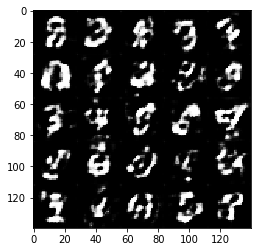

Epoch 2/2... Discriminator loss: 1.1774... Generator loss: 0.7983
Epoch 2/2... Discriminator loss: 1.1553... Generator loss: 1.1172
Epoch 2/2... Discriminator loss: 1.1822... Generator loss: 1.0912
Epoch 2/2... Discriminator loss: 1.1773... Generator loss: 0.9693
Epoch 2/2... Discriminator loss: 1.1910... Generator loss: 0.7424
Epoch 2/2... Discriminator loss: 1.1384... Generator loss: 0.9126
Epoch 2/2... Discriminator loss: 1.1660... Generator loss: 0.8721
Epoch 2/2... Discriminator loss: 1.1191... Generator loss: 1.1865
Epoch 2/2... Discriminator loss: 1.1680... Generator loss: 1.3143
Epoch 2/2... Discriminator loss: 1.2175... Generator loss: 1.2862


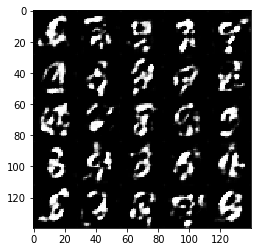

Epoch 2/2... Discriminator loss: 1.1381... Generator loss: 1.0708
Epoch 2/2... Discriminator loss: 1.1469... Generator loss: 0.9533
Epoch 2/2... Discriminator loss: 1.2007... Generator loss: 1.3888
Epoch 2/2... Discriminator loss: 1.1164... Generator loss: 1.0233
Epoch 2/2... Discriminator loss: 1.1453... Generator loss: 0.8295
Epoch 2/2... Discriminator loss: 1.1425... Generator loss: 0.9322
Epoch 2/2... Discriminator loss: 1.1566... Generator loss: 1.0700
Epoch 2/2... Discriminator loss: 1.1206... Generator loss: 1.0502
Epoch 2/2... Discriminator loss: 1.1224... Generator loss: 1.1922
Epoch 2/2... Discriminator loss: 1.1307... Generator loss: 1.0132


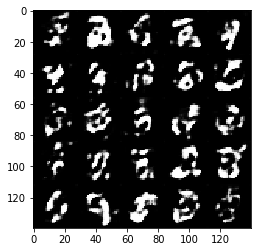

Epoch 2/2... Discriminator loss: 1.1871... Generator loss: 1.1373
Epoch 2/2... Discriminator loss: 1.1585... Generator loss: 0.8470
Epoch 2/2... Discriminator loss: 1.1387... Generator loss: 1.0125
Epoch 2/2... Discriminator loss: 1.1448... Generator loss: 0.8803
Epoch 2/2... Discriminator loss: 1.2683... Generator loss: 1.3955
Epoch 2/2... Discriminator loss: 1.1556... Generator loss: 1.1037
Epoch 2/2... Discriminator loss: 1.1277... Generator loss: 0.8387
Epoch 2/2... Discriminator loss: 1.1272... Generator loss: 0.9697
Epoch 2/2... Discriminator loss: 1.0922... Generator loss: 0.9391
Epoch 2/2... Discriminator loss: 1.1355... Generator loss: 0.9716


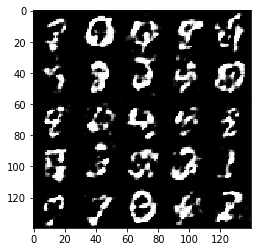

Epoch 2/2... Discriminator loss: 1.1293... Generator loss: 1.0122
Epoch 2/2... Discriminator loss: 1.1487... Generator loss: 1.0915
Epoch 2/2... Discriminator loss: 1.1299... Generator loss: 1.2097
Epoch 2/2... Discriminator loss: 1.1267... Generator loss: 0.9541
Epoch 2/2... Discriminator loss: 1.1402... Generator loss: 1.2302
Epoch 2/2... Discriminator loss: 1.1215... Generator loss: 1.1105
Epoch 2/2... Discriminator loss: 1.1355... Generator loss: 1.0296
Epoch 2/2... Discriminator loss: 1.0888... Generator loss: 0.9575
Epoch 2/2... Discriminator loss: 1.1386... Generator loss: 1.2910
Epoch 2/2... Discriminator loss: 1.1149... Generator loss: 1.0600


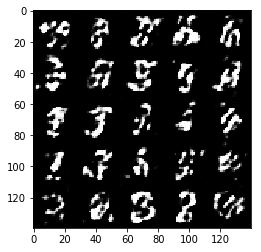

Epoch 2/2... Discriminator loss: 1.1108... Generator loss: 0.9415
Epoch 2/2... Discriminator loss: 1.1036... Generator loss: 1.0757
Epoch 2/2... Discriminator loss: 1.1158... Generator loss: 1.1141


In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.00004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator loss: 1.1748... Generator loss: 0.5827
Epoch 1/1... Discriminator loss: 0.7055... Generator loss: 1.2378
Epoch 1/1... Discriminator loss: 0.4262... Generator loss: 2.9069
Epoch 1/1... Discriminator loss: 0.4265... Generator loss: 2.9439
Epoch 1/1... Discriminator loss: 0.4200... Generator loss: 3.3569
Epoch 1/1... Discriminator loss: 0.4935... Generator loss: 2.6661
Epoch 1/1... Discriminator loss: 0.7441... Generator loss: 1.3518
Epoch 1/1... Discriminator loss: 1.6295... Generator loss: 5.5116
Epoch 1/1... Discriminator loss: 0.6881... Generator loss: 1.5804
Epoch 1/1... Discriminator loss: 0.8751... Generator loss: 1.6970


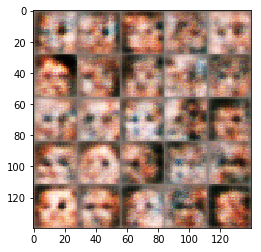

Epoch 1/1... Discriminator loss: 1.8781... Generator loss: 2.9162
Epoch 1/1... Discriminator loss: 0.9274... Generator loss: 1.8417
Epoch 1/1... Discriminator loss: 1.0416... Generator loss: 1.1162
Epoch 1/1... Discriminator loss: 1.7013... Generator loss: 0.9653
Epoch 1/1... Discriminator loss: 1.5126... Generator loss: 0.6970
Epoch 1/1... Discriminator loss: 1.2249... Generator loss: 1.1683
Epoch 1/1... Discriminator loss: 1.1447... Generator loss: 1.0788
Epoch 1/1... Discriminator loss: 1.2531... Generator loss: 1.2629
Epoch 1/1... Discriminator loss: 1.2758... Generator loss: 1.0942
Epoch 1/1... Discriminator loss: 1.2958... Generator loss: 0.7897


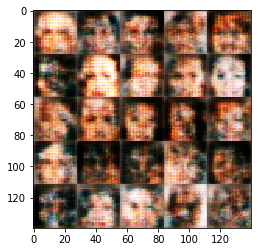

Epoch 1/1... Discriminator loss: 1.1692... Generator loss: 0.8835
Epoch 1/1... Discriminator loss: 1.3471... Generator loss: 0.8741
Epoch 1/1... Discriminator loss: 1.3425... Generator loss: 0.9055
Epoch 1/1... Discriminator loss: 1.1511... Generator loss: 1.0283
Epoch 1/1... Discriminator loss: 1.2661... Generator loss: 0.7726
Epoch 1/1... Discriminator loss: 1.3451... Generator loss: 0.9705
Epoch 1/1... Discriminator loss: 1.1664... Generator loss: 0.9762
Epoch 1/1... Discriminator loss: 1.3310... Generator loss: 0.6784
Epoch 1/1... Discriminator loss: 1.2650... Generator loss: 1.1191
Epoch 1/1... Discriminator loss: 1.2503... Generator loss: 1.1344


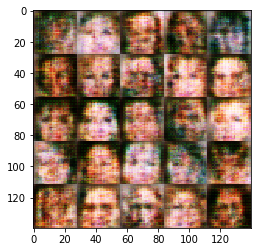

Epoch 1/1... Discriminator loss: 1.2151... Generator loss: 1.0018
Epoch 1/1... Discriminator loss: 1.2332... Generator loss: 0.9292
Epoch 1/1... Discriminator loss: 1.4100... Generator loss: 0.9298
Epoch 1/1... Discriminator loss: 1.2969... Generator loss: 0.8990
Epoch 1/1... Discriminator loss: 1.2129... Generator loss: 0.9891
Epoch 1/1... Discriminator loss: 1.3786... Generator loss: 0.7914
Epoch 1/1... Discriminator loss: 1.3117... Generator loss: 0.7604
Epoch 1/1... Discriminator loss: 1.2221... Generator loss: 0.9536
Epoch 1/1... Discriminator loss: 1.2914... Generator loss: 0.9240
Epoch 1/1... Discriminator loss: 1.2583... Generator loss: 0.8750


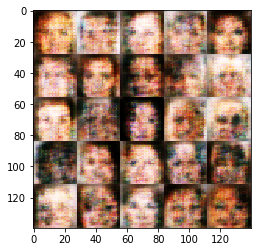

Epoch 1/1... Discriminator loss: 1.2209... Generator loss: 0.9063
Epoch 1/1... Discriminator loss: 1.2271... Generator loss: 0.9702
Epoch 1/1... Discriminator loss: 1.2529... Generator loss: 0.8386
Epoch 1/1... Discriminator loss: 1.4097... Generator loss: 0.6598
Epoch 1/1... Discriminator loss: 1.3759... Generator loss: 1.0974
Epoch 1/1... Discriminator loss: 1.3529... Generator loss: 0.7772
Epoch 1/1... Discriminator loss: 1.2013... Generator loss: 0.9126
Epoch 1/1... Discriminator loss: 1.4510... Generator loss: 0.8137
Epoch 1/1... Discriminator loss: 1.3903... Generator loss: 0.7430
Epoch 1/1... Discriminator loss: 1.3728... Generator loss: 0.8114


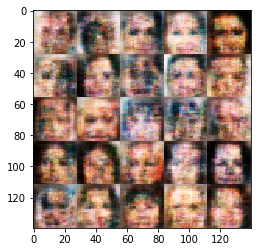

Epoch 1/1... Discriminator loss: 1.2777... Generator loss: 0.9630
Epoch 1/1... Discriminator loss: 1.3136... Generator loss: 0.8812
Epoch 1/1... Discriminator loss: 1.4004... Generator loss: 0.7001
Epoch 1/1... Discriminator loss: 1.3217... Generator loss: 0.7467
Epoch 1/1... Discriminator loss: 1.2936... Generator loss: 0.8542
Epoch 1/1... Discriminator loss: 1.3658... Generator loss: 0.7474
Epoch 1/1... Discriminator loss: 1.3889... Generator loss: 0.9198
Epoch 1/1... Discriminator loss: 1.3047... Generator loss: 0.8593
Epoch 1/1... Discriminator loss: 1.4211... Generator loss: 0.8044
Epoch 1/1... Discriminator loss: 1.3108... Generator loss: 0.8549


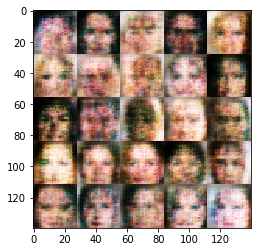

Epoch 1/1... Discriminator loss: 1.3767... Generator loss: 0.6966
Epoch 1/1... Discriminator loss: 1.4341... Generator loss: 0.7388
Epoch 1/1... Discriminator loss: 1.3954... Generator loss: 0.8370
Epoch 1/1... Discriminator loss: 1.3443... Generator loss: 0.7722
Epoch 1/1... Discriminator loss: 1.2808... Generator loss: 0.9235
Epoch 1/1... Discriminator loss: 1.4049... Generator loss: 0.7288
Epoch 1/1... Discriminator loss: 1.3325... Generator loss: 0.7937
Epoch 1/1... Discriminator loss: 1.3042... Generator loss: 0.9229
Epoch 1/1... Discriminator loss: 1.2855... Generator loss: 0.8809
Epoch 1/1... Discriminator loss: 1.3622... Generator loss: 0.7791


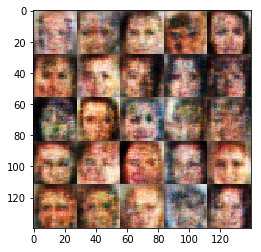

Epoch 1/1... Discriminator loss: 1.2652... Generator loss: 0.8799
Epoch 1/1... Discriminator loss: 1.2695... Generator loss: 0.8382
Epoch 1/1... Discriminator loss: 1.3068... Generator loss: 0.8644
Epoch 1/1... Discriminator loss: 1.2818... Generator loss: 0.7904
Epoch 1/1... Discriminator loss: 1.3577... Generator loss: 0.8105
Epoch 1/1... Discriminator loss: 1.3828... Generator loss: 0.7725
Epoch 1/1... Discriminator loss: 1.3629... Generator loss: 0.7843
Epoch 1/1... Discriminator loss: 1.3107... Generator loss: 0.8730
Epoch 1/1... Discriminator loss: 1.3588... Generator loss: 0.8565
Epoch 1/1... Discriminator loss: 1.3595... Generator loss: 0.8446


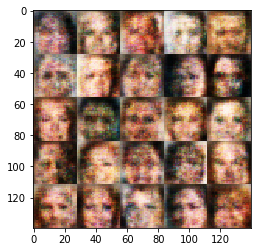

Epoch 1/1... Discriminator loss: 1.3296... Generator loss: 0.8168
Epoch 1/1... Discriminator loss: 1.2997... Generator loss: 0.7838
Epoch 1/1... Discriminator loss: 1.3964... Generator loss: 0.8539
Epoch 1/1... Discriminator loss: 1.3818... Generator loss: 0.8609
Epoch 1/1... Discriminator loss: 1.3616... Generator loss: 0.8004
Epoch 1/1... Discriminator loss: 1.3694... Generator loss: 0.8502
Epoch 1/1... Discriminator loss: 1.2999... Generator loss: 0.9696
Epoch 1/1... Discriminator loss: 1.3573... Generator loss: 0.8269
Epoch 1/1... Discriminator loss: 1.4053... Generator loss: 0.8112
Epoch 1/1... Discriminator loss: 1.2446... Generator loss: 0.9391


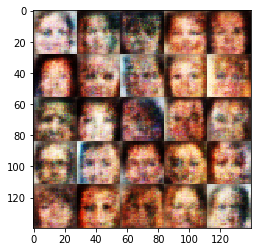

Epoch 1/1... Discriminator loss: 1.3369... Generator loss: 0.7406
Epoch 1/1... Discriminator loss: 1.2484... Generator loss: 0.9009
Epoch 1/1... Discriminator loss: 1.4432... Generator loss: 0.7542
Epoch 1/1... Discriminator loss: 1.2412... Generator loss: 0.8697
Epoch 1/1... Discriminator loss: 1.4044... Generator loss: 0.8213
Epoch 1/1... Discriminator loss: 1.4322... Generator loss: 0.7067
Epoch 1/1... Discriminator loss: 1.2671... Generator loss: 0.8622
Epoch 1/1... Discriminator loss: 1.3455... Generator loss: 0.7184
Epoch 1/1... Discriminator loss: 1.3532... Generator loss: 0.8664
Epoch 1/1... Discriminator loss: 1.3961... Generator loss: 0.7324


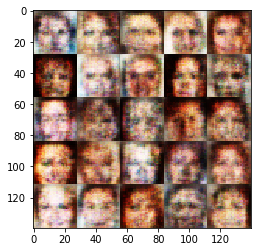

Epoch 1/1... Discriminator loss: 1.3906... Generator loss: 0.7778
Epoch 1/1... Discriminator loss: 1.2836... Generator loss: 0.8491
Epoch 1/1... Discriminator loss: 1.3746... Generator loss: 0.8788
Epoch 1/1... Discriminator loss: 1.3182... Generator loss: 0.6874
Epoch 1/1... Discriminator loss: 1.3349... Generator loss: 0.7676
Epoch 1/1... Discriminator loss: 1.3682... Generator loss: 0.8933
Epoch 1/1... Discriminator loss: 1.3532... Generator loss: 0.8695
Epoch 1/1... Discriminator loss: 1.3268... Generator loss: 0.7718
Epoch 1/1... Discriminator loss: 1.3525... Generator loss: 0.7716
Epoch 1/1... Discriminator loss: 1.3703... Generator loss: 0.7802


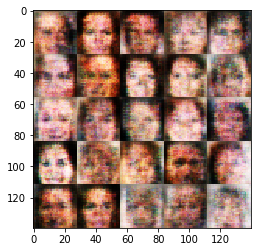

Epoch 1/1... Discriminator loss: 1.3794... Generator loss: 0.7990
Epoch 1/1... Discriminator loss: 1.3975... Generator loss: 0.7462
Epoch 1/1... Discriminator loss: 1.3095... Generator loss: 0.8867
Epoch 1/1... Discriminator loss: 1.2597... Generator loss: 0.8113
Epoch 1/1... Discriminator loss: 1.4027... Generator loss: 0.7963
Epoch 1/1... Discriminator loss: 1.3065... Generator loss: 0.9177
Epoch 1/1... Discriminator loss: 1.1997... Generator loss: 0.7990
Epoch 1/1... Discriminator loss: 1.2643... Generator loss: 0.9032
Epoch 1/1... Discriminator loss: 1.3147... Generator loss: 0.9178
Epoch 1/1... Discriminator loss: 1.2986... Generator loss: 0.9043


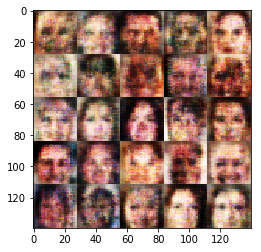

Epoch 1/1... Discriminator loss: 1.3242... Generator loss: 0.8487
Epoch 1/1... Discriminator loss: 1.2974... Generator loss: 0.9029
Epoch 1/1... Discriminator loss: 1.3031... Generator loss: 0.8817
Epoch 1/1... Discriminator loss: 1.2446... Generator loss: 0.9146
Epoch 1/1... Discriminator loss: 1.3427... Generator loss: 0.8921
Epoch 1/1... Discriminator loss: 1.3432... Generator loss: 0.8261
Epoch 1/1... Discriminator loss: 1.2481... Generator loss: 0.8657
Epoch 1/1... Discriminator loss: 1.3136... Generator loss: 0.8164
Epoch 1/1... Discriminator loss: 1.2336... Generator loss: 0.9586
Epoch 1/1... Discriminator loss: 1.3138... Generator loss: 0.9289


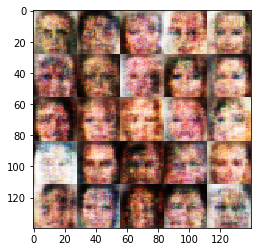

Epoch 1/1... Discriminator loss: 1.3673... Generator loss: 0.9866
Epoch 1/1... Discriminator loss: 1.3599... Generator loss: 0.8562
Epoch 1/1... Discriminator loss: 1.1511... Generator loss: 1.0045
Epoch 1/1... Discriminator loss: 1.4227... Generator loss: 0.8139
Epoch 1/1... Discriminator loss: 1.3388... Generator loss: 0.7616
Epoch 1/1... Discriminator loss: 1.2655... Generator loss: 0.8558
Epoch 1/1... Discriminator loss: 1.4037... Generator loss: 0.8120
Epoch 1/1... Discriminator loss: 1.3193... Generator loss: 0.9353
Epoch 1/1... Discriminator loss: 1.2695... Generator loss: 0.9001
Epoch 1/1... Discriminator loss: 1.3136... Generator loss: 0.8783


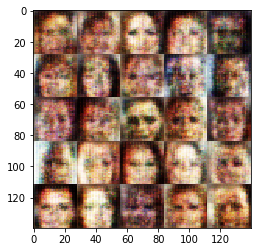

Epoch 1/1... Discriminator loss: 1.2093... Generator loss: 0.9556
Epoch 1/1... Discriminator loss: 1.1818... Generator loss: 1.0367
Epoch 1/1... Discriminator loss: 1.3196... Generator loss: 0.8403
Epoch 1/1... Discriminator loss: 1.3402... Generator loss: 0.8633
Epoch 1/1... Discriminator loss: 1.2966... Generator loss: 0.9101
Epoch 1/1... Discriminator loss: 1.2335... Generator loss: 0.9221
Epoch 1/1... Discriminator loss: 1.2688... Generator loss: 0.9170
Epoch 1/1... Discriminator loss: 1.3275... Generator loss: 0.7815
Epoch 1/1... Discriminator loss: 1.3867... Generator loss: 0.8369
Epoch 1/1... Discriminator loss: 1.3018... Generator loss: 0.8625


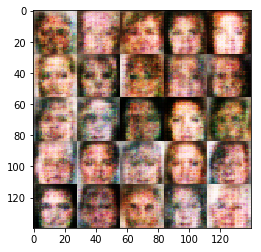

Epoch 1/1... Discriminator loss: 1.2944... Generator loss: 1.0463
Epoch 1/1... Discriminator loss: 1.2349... Generator loss: 0.9281
Epoch 1/1... Discriminator loss: 1.2729... Generator loss: 1.0182
Epoch 1/1... Discriminator loss: 1.2803... Generator loss: 0.7904
Epoch 1/1... Discriminator loss: 1.2720... Generator loss: 0.9551
Epoch 1/1... Discriminator loss: 1.3092... Generator loss: 0.8345
Epoch 1/1... Discriminator loss: 1.3421... Generator loss: 0.8922
Epoch 1/1... Discriminator loss: 1.1661... Generator loss: 1.0020
Epoch 1/1... Discriminator loss: 1.2083... Generator loss: 1.0414
Epoch 1/1... Discriminator loss: 1.3109... Generator loss: 0.8252


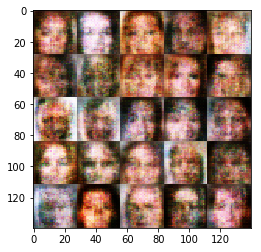

Epoch 1/1... Discriminator loss: 1.2642... Generator loss: 0.8941
Epoch 1/1... Discriminator loss: 1.2918... Generator loss: 0.9443
Epoch 1/1... Discriminator loss: 1.2406... Generator loss: 0.9118
Epoch 1/1... Discriminator loss: 1.2717... Generator loss: 0.7918
Epoch 1/1... Discriminator loss: 1.3739... Generator loss: 0.8580
Epoch 1/1... Discriminator loss: 1.2371... Generator loss: 0.9807
Epoch 1/1... Discriminator loss: 1.2281... Generator loss: 0.8880
Epoch 1/1... Discriminator loss: 1.2587... Generator loss: 0.9584
Epoch 1/1... Discriminator loss: 1.2691... Generator loss: 0.7933
Epoch 1/1... Discriminator loss: 1.2363... Generator loss: 0.8190


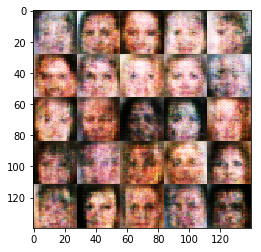

Epoch 1/1... Discriminator loss: 1.2111... Generator loss: 0.9282
Epoch 1/1... Discriminator loss: 1.2260... Generator loss: 0.8890
Epoch 1/1... Discriminator loss: 1.2862... Generator loss: 0.9625
Epoch 1/1... Discriminator loss: 1.2453... Generator loss: 0.8622
Epoch 1/1... Discriminator loss: 1.2032... Generator loss: 1.0197
Epoch 1/1... Discriminator loss: 1.2002... Generator loss: 0.9554
Epoch 1/1... Discriminator loss: 1.3878... Generator loss: 0.8609
Epoch 1/1... Discriminator loss: 1.1709... Generator loss: 1.0289
Epoch 1/1... Discriminator loss: 1.1777... Generator loss: 0.9580
Epoch 1/1... Discriminator loss: 1.1835... Generator loss: 0.9805


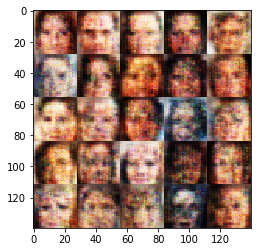

Epoch 1/1... Discriminator loss: 1.3059... Generator loss: 0.8682
Epoch 1/1... Discriminator loss: 1.2787... Generator loss: 0.8479
Epoch 1/1... Discriminator loss: 1.3329... Generator loss: 0.9201
Epoch 1/1... Discriminator loss: 1.1698... Generator loss: 0.9680
Epoch 1/1... Discriminator loss: 1.2309... Generator loss: 0.9163
Epoch 1/1... Discriminator loss: 1.2235... Generator loss: 0.9351
Epoch 1/1... Discriminator loss: 1.1727... Generator loss: 0.8944
Epoch 1/1... Discriminator loss: 1.2189... Generator loss: 0.9824
Epoch 1/1... Discriminator loss: 1.3059... Generator loss: 0.8096
Epoch 1/1... Discriminator loss: 1.1725... Generator loss: 0.9550


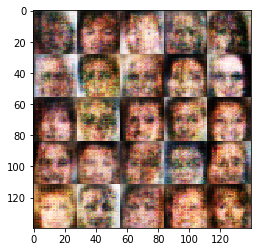

Epoch 1/1... Discriminator loss: 1.1335... Generator loss: 0.9347
Epoch 1/1... Discriminator loss: 1.1861... Generator loss: 1.0386
Epoch 1/1... Discriminator loss: 1.2282... Generator loss: 1.0605
Epoch 1/1... Discriminator loss: 1.2095... Generator loss: 0.9997
Epoch 1/1... Discriminator loss: 1.2407... Generator loss: 0.8525
Epoch 1/1... Discriminator loss: 1.2722... Generator loss: 0.8112
Epoch 1/1... Discriminator loss: 1.2174... Generator loss: 0.9741
Epoch 1/1... Discriminator loss: 1.2318... Generator loss: 1.0117
Epoch 1/1... Discriminator loss: 1.2418... Generator loss: 0.8916
Epoch 1/1... Discriminator loss: 1.1419... Generator loss: 1.0100


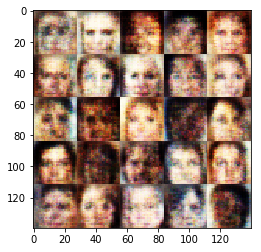

Epoch 1/1... Discriminator loss: 1.2767... Generator loss: 0.8823
Epoch 1/1... Discriminator loss: 1.2419... Generator loss: 1.1694
Epoch 1/1... Discriminator loss: 1.1763... Generator loss: 1.0278
Epoch 1/1... Discriminator loss: 1.2205... Generator loss: 0.9222
Epoch 1/1... Discriminator loss: 1.1849... Generator loss: 0.9863
Epoch 1/1... Discriminator loss: 1.1001... Generator loss: 0.9967
Epoch 1/1... Discriminator loss: 1.2338... Generator loss: 0.8740
Epoch 1/1... Discriminator loss: 1.2438... Generator loss: 1.1209
Epoch 1/1... Discriminator loss: 1.1873... Generator loss: 0.8814
Epoch 1/1... Discriminator loss: 1.1910... Generator loss: 1.1697


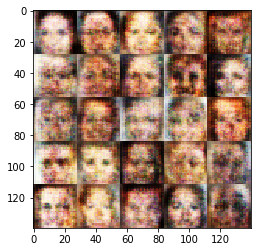

Epoch 1/1... Discriminator loss: 1.2391... Generator loss: 0.9730
Epoch 1/1... Discriminator loss: 1.2176... Generator loss: 0.9174
Epoch 1/1... Discriminator loss: 1.2278... Generator loss: 1.0636
Epoch 1/1... Discriminator loss: 1.2846... Generator loss: 0.8340
Epoch 1/1... Discriminator loss: 1.2486... Generator loss: 0.9431
Epoch 1/1... Discriminator loss: 1.1615... Generator loss: 1.0814
Epoch 1/1... Discriminator loss: 1.1342... Generator loss: 1.0143
Epoch 1/1... Discriminator loss: 1.2020... Generator loss: 0.9340
Epoch 1/1... Discriminator loss: 1.2400... Generator loss: 0.9101
Epoch 1/1... Discriminator loss: 1.2380... Generator loss: 0.9104


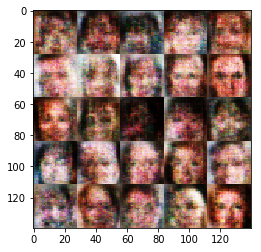

Epoch 1/1... Discriminator loss: 1.1152... Generator loss: 1.0058
Epoch 1/1... Discriminator loss: 1.3239... Generator loss: 0.8210
Epoch 1/1... Discriminator loss: 1.1677... Generator loss: 0.9700
Epoch 1/1... Discriminator loss: 1.1172... Generator loss: 0.9331
Epoch 1/1... Discriminator loss: 1.1161... Generator loss: 1.0532
Epoch 1/1... Discriminator loss: 1.1271... Generator loss: 1.1267
Epoch 1/1... Discriminator loss: 1.2682... Generator loss: 0.8148
Epoch 1/1... Discriminator loss: 1.2802... Generator loss: 0.8205
Epoch 1/1... Discriminator loss: 1.2590... Generator loss: 0.9124
Epoch 1/1... Discriminator loss: 1.1638... Generator loss: 1.1128


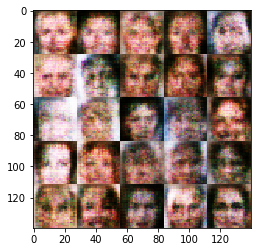

Epoch 1/1... Discriminator loss: 1.2502... Generator loss: 0.8510
Epoch 1/1... Discriminator loss: 1.2155... Generator loss: 0.9221
Epoch 1/1... Discriminator loss: 1.1370... Generator loss: 0.9934
Epoch 1/1... Discriminator loss: 1.2434... Generator loss: 1.0354
Epoch 1/1... Discriminator loss: 1.1770... Generator loss: 0.9050
Epoch 1/1... Discriminator loss: 1.0670... Generator loss: 1.0131
Epoch 1/1... Discriminator loss: 1.2402... Generator loss: 0.9599
Epoch 1/1... Discriminator loss: 1.0894... Generator loss: 1.0911
Epoch 1/1... Discriminator loss: 1.1233... Generator loss: 1.0182
Epoch 1/1... Discriminator loss: 1.1334... Generator loss: 1.1593


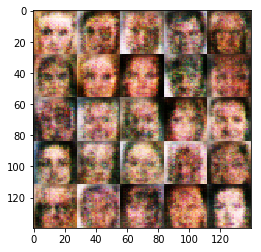

Epoch 1/1... Discriminator loss: 1.1079... Generator loss: 0.9702
Epoch 1/1... Discriminator loss: 1.2070... Generator loss: 0.9878
Epoch 1/1... Discriminator loss: 1.0843... Generator loss: 1.0223
Epoch 1/1... Discriminator loss: 1.1286... Generator loss: 0.9530
Epoch 1/1... Discriminator loss: 1.1490... Generator loss: 1.1797
Epoch 1/1... Discriminator loss: 1.0622... Generator loss: 1.1423
Epoch 1/1... Discriminator loss: 1.1611... Generator loss: 1.2749
Epoch 1/1... Discriminator loss: 1.1849... Generator loss: 0.8541
Epoch 1/1... Discriminator loss: 1.0819... Generator loss: 1.1512
Epoch 1/1... Discriminator loss: 1.1397... Generator loss: 1.0774


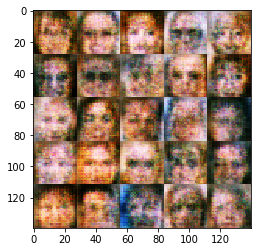

Epoch 1/1... Discriminator loss: 1.1079... Generator loss: 1.0106
Epoch 1/1... Discriminator loss: 1.1607... Generator loss: 1.0161
Epoch 1/1... Discriminator loss: 1.0719... Generator loss: 1.2606
Epoch 1/1... Discriminator loss: 1.1458... Generator loss: 0.9716
Epoch 1/1... Discriminator loss: 1.0505... Generator loss: 1.0690
Epoch 1/1... Discriminator loss: 1.2100... Generator loss: 0.8469
Epoch 1/1... Discriminator loss: 1.2445... Generator loss: 0.8698
Epoch 1/1... Discriminator loss: 1.0760... Generator loss: 1.0622
Epoch 1/1... Discriminator loss: 1.0372... Generator loss: 1.2850
Epoch 1/1... Discriminator loss: 1.0468... Generator loss: 1.1437


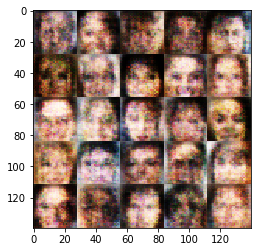

Epoch 1/1... Discriminator loss: 1.2578... Generator loss: 0.9707
Epoch 1/1... Discriminator loss: 1.1473... Generator loss: 1.0673
Epoch 1/1... Discriminator loss: 1.1668... Generator loss: 1.1267
Epoch 1/1... Discriminator loss: 1.1132... Generator loss: 1.1141
Epoch 1/1... Discriminator loss: 1.0803... Generator loss: 1.0963
Epoch 1/1... Discriminator loss: 1.1078... Generator loss: 1.0227
Epoch 1/1... Discriminator loss: 1.0979... Generator loss: 1.3060
Epoch 1/1... Discriminator loss: 1.0290... Generator loss: 1.1890
Epoch 1/1... Discriminator loss: 1.1501... Generator loss: 1.3034
Epoch 1/1... Discriminator loss: 1.0215... Generator loss: 1.3125


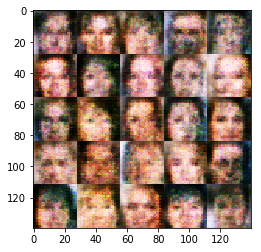

Epoch 1/1... Discriminator loss: 1.1658... Generator loss: 0.9698
Epoch 1/1... Discriminator loss: 0.9774... Generator loss: 1.1584
Epoch 1/1... Discriminator loss: 1.1298... Generator loss: 1.0789
Epoch 1/1... Discriminator loss: 1.0701... Generator loss: 1.1124
Epoch 1/1... Discriminator loss: 1.1108... Generator loss: 1.2383
Epoch 1/1... Discriminator loss: 1.1227... Generator loss: 1.0465
Epoch 1/1... Discriminator loss: 1.1554... Generator loss: 0.9761
Epoch 1/1... Discriminator loss: 1.0954... Generator loss: 1.0087
Epoch 1/1... Discriminator loss: 0.9913... Generator loss: 1.1447
Epoch 1/1... Discriminator loss: 1.0213... Generator loss: 1.0721


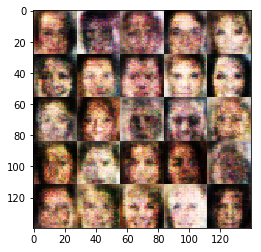

Epoch 1/1... Discriminator loss: 1.1263... Generator loss: 0.8883
Epoch 1/1... Discriminator loss: 1.0439... Generator loss: 0.9538
Epoch 1/1... Discriminator loss: 1.0003... Generator loss: 1.1718
Epoch 1/1... Discriminator loss: 1.1042... Generator loss: 1.1195
Epoch 1/1... Discriminator loss: 0.9344... Generator loss: 1.3243
Epoch 1/1... Discriminator loss: 1.1050... Generator loss: 1.0488
Epoch 1/1... Discriminator loss: 1.0712... Generator loss: 1.2455
Epoch 1/1... Discriminator loss: 1.0354... Generator loss: 1.1730
Epoch 1/1... Discriminator loss: 1.0755... Generator loss: 1.1286
Epoch 1/1... Discriminator loss: 1.0644... Generator loss: 1.1418


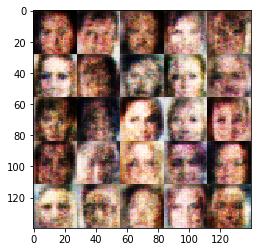

Epoch 1/1... Discriminator loss: 1.0601... Generator loss: 1.0720
Epoch 1/1... Discriminator loss: 1.0496... Generator loss: 1.1861
Epoch 1/1... Discriminator loss: 1.1337... Generator loss: 0.9722
Epoch 1/1... Discriminator loss: 1.0009... Generator loss: 1.0993
Epoch 1/1... Discriminator loss: 1.0355... Generator loss: 1.2089
Epoch 1/1... Discriminator loss: 1.0217... Generator loss: 1.3327
Epoch 1/1... Discriminator loss: 1.0419... Generator loss: 1.2091
Epoch 1/1... Discriminator loss: 1.0686... Generator loss: 1.2089
Epoch 1/1... Discriminator loss: 1.0249... Generator loss: 1.1774
Epoch 1/1... Discriminator loss: 1.0991... Generator loss: 1.1660


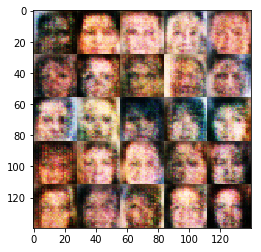

Epoch 1/1... Discriminator loss: 1.0878... Generator loss: 1.1768
Epoch 1/1... Discriminator loss: 0.9713... Generator loss: 1.2300
Epoch 1/1... Discriminator loss: 1.0213... Generator loss: 1.2591
Epoch 1/1... Discriminator loss: 1.1376... Generator loss: 1.0220
Epoch 1/1... Discriminator loss: 1.0200... Generator loss: 1.0683
Epoch 1/1... Discriminator loss: 1.1133... Generator loss: 1.0640
Epoch 1/1... Discriminator loss: 1.0038... Generator loss: 1.1094
Epoch 1/1... Discriminator loss: 1.0394... Generator loss: 1.1383
Epoch 1/1... Discriminator loss: 1.0352... Generator loss: 1.1147
Epoch 1/1... Discriminator loss: 0.9479... Generator loss: 1.2097


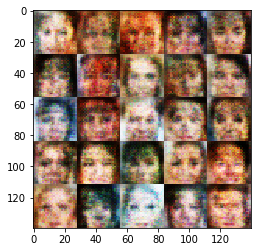

Epoch 1/1... Discriminator loss: 0.9875... Generator loss: 1.1398
Epoch 1/1... Discriminator loss: 1.0417... Generator loss: 1.1921
Epoch 1/1... Discriminator loss: 1.1284... Generator loss: 1.0164
Epoch 1/1... Discriminator loss: 1.0394... Generator loss: 1.1591
Epoch 1/1... Discriminator loss: 1.0661... Generator loss: 0.9504
Epoch 1/1... Discriminator loss: 1.0247... Generator loss: 1.1740


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.